<img src='./img/LogoWekeo_Copernicus_RGB_0.png' align='right' width='20%'></img>

# Tutorial on climate data access through WEkEO

This tutorial focusses on how to access climate data through [WEkEO](https://www.wekeo.eu/), the EU Copernicus DIAS (Data and Information Access Service) reference service for environmental data. In addition to data, WEkEO provides virtual processing environments and skilled user support.

WEkEO offers access to satellite data from the Sentinel missions, and many products produced by the Copernicus climate change, atmosphere, marine and land monitoring services. 

The Copernicus Climate Change service provides authoritative information about the past, present and future climate. Its product portfolio includes the following:

- **Satellite and in-situ observations**
- **Reanalysis**
- **Seasonal forecasts**
- **Climate projections**
- **Climate indices**

This data is accessible through the [C3S Climate Data Store (CDS)](https://cds.climate.copernicus.eu/), and in future also through WEkEO. While some C3S datasets are available through WEkEO, this is still work in progress. This Jupyter Notebook demonstrates how to access data through WEkEO, but please be aware that for the time being, C3S data should be accessed via the CDS. 

Users can access data from WEkEO either directly from the [WEkEO web platform](https://www.wekeo.eu/), or through the [Harmonised Data Access (HDA) API](https://www.wekeo.eu/documentation/using_jupyter_notebooks), which is a REST interface.

This Jupyter Notebook is a step-by-step guide on how to search for and download data from WEkEO using the `HDA API`. It makes use of functions stored in the notebook [hda_api_functions](./hda_api_functions.ipynb).

The tutorial consists of the following steps:

1. [Search for datasets on WEkEO](#wekeo_search)
2. [Get your WEkEO API key](#wekeo_api_key)
3. [Initialise the WEkEO Harmonised Data Access request](#wekeo_hda_request)
4. [Load data descriptor file and request data](#wekeo_request)
5. [Download requested data](#wekeo_download)
 
Having downloaded data, follow the step below to view it and create a simple plot:
 
6. [View and plot data](#wekeo_view)

#### Load required libraries

In [1]:
import os
import sys
import json
from zipfile import ZipFile
import time
import base64
from IPython.core.display import HTML

import requests
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import xarray as xr

#### Load helper functions

In [3]:
from hda_api_functions import *

<hr>

### <a id='wekeo_search'></a>1. Search for datasets on WEkEO

Under [WEkEO DATA](https://wekeo.eu/data?view=catalogue). Clicking the + to add a layer, opens a catalogue search. Here you can use free text, or you can use the filter options on the left to refine your search and look by satellite plaform, sensor, Copernicus service, area (region of interest), general time period (past or future), as well as through a variety of flags.

You can click on the dataset you are interested in and you will be guided to a range of details including the dataset temporal and spatial extent, collection ID, and metadata.

Now search for the product `Sea level daily gridded data for the global ocean from 1993 to present`. You can find it more easily by selecting 'C3S (Climate)' in the 'COPERNICUS SERVICE' filter group. 

Once you have found it, select 'Details' to read the dataset description.

<br>

<div style='text-align:center;'>
<figure><img src='./img/WEkEO_data.png' width='70%' />
    <figcaption><i>WEkEO interface to search for datasets</i></figcaption>
</figure>
</div>

The dataset description provides the following information:
- **Abstract**, containing a general description of the dataset,
- **Classification**, including the Dataset ID 
- **Resources**, such as a link to the Product Data Format Specification guide, and JSON metadata
- **Contacts**, where you can find further information about the data source from its provider.  

You need the `Dataset ID` to request data from the Harmonised Data Access API. 

<br>

<div style='text-align:center;'>
<figure><img src='./img/SeaLevel_info.png' width='40%' />
    <figcaption><i>Dataset information on WEkEO</i></figcaption>
</figure>
</div>
<br>

Let's store the Dataset ID as a variable called `dataset_id` to be used later.

In [4]:
dataset_id = "EO:ECMWF:DAT:SEA_LEVEL_DAILY_GRIDDED_DATA_FOR_GL"

Now select `Add to map` in the data description to add the selected dataset to the list of layers in your map view. Once the dataset appears as a layer, select the `subset and download` icon. This will enable you to specify the variables, temporal and in some cases geographic extent of the data you would like to download. Select `2019` as year, `August` as month, and `15` as day. Then select `Zip file` as format.

Now select `Show API request`. This will show the details of your selection in `JSON` format. If you now select `Copy`, you can copy these details to the clipboard then paste it either into a text file to create a `JSON` file (see example [here](./SeaLevel_data_descriptor.json)), or paste it directly into the cell below.

The Harmonised Data Access API can read this information, which is in the form of a dictionary with the following keys:
- `datasetID`: the dataset's collection ID
- `stringChoiceValues`: type of dataset, e.g. 'Non Time Critical'
- `dataRangeSelectValues`: time period you would like to retrieve data
- `boundingBoxValues`: optional to define a subset of a global field

<br>

<div style='text-align:center;'>
<figure><img src='./img/SeaLevel_params_json.png' width='60%' />
    <figcaption><i>Displaying a JSON query from a request made to the Harmonised Data Access API through the data portal</i></figcaption>
</figure>
</div>
<br>

If you created a `JSON` file, you can load it with `json.load()`:

In [5]:
try:
    with open('./SeaLevel_data_descriptor.json', 'r') as f:
        data = json.load(f)
    print('Your JSON file:')
    print(data)
except:
    print('Your JSON file is not in the correct format, or is not found, please check it!')

Your JSON file:
{'datasetId': 'EO:ECMWF:DAT:SEA_LEVEL_DAILY_GRIDDED_DATA_FOR_GLOBAL_OCEAN_1993_PRESENT', 'multiStringSelectValues': [{'name': 'variable', 'value': ['all']}, {'name': 'year', 'value': ['2019']}, {'name': 'month', 'value': ['08']}, {'name': 'day', 'value': ['15']}], 'stringChoiceValues': [{'name': 'format', 'value': 'zip'}]}


Alternatively, you can paste the dictionary describing your data into a cell, as done below:

In [6]:
data = {
  "datasetId": "EO:ECMWF:DAT:SEA_LEVEL_DAILY_GRIDDED_DATA_FOR_GLOBAL_OCEAN_1993_PRESENT",
  "multiStringSelectValues": [
    {
      "name": "variable",
      "value": [
        "all"
      ]
    },
    {
      "name": "year",
      "value": [
        "2019"
      ]
    },
    {
      "name": "month",
      "value": [
        "08"
      ]
    },
    {
      "name": "day",
      "value": [
        "15"
      ]
    }
  ],
  "stringChoiceValues": [
    {
      "name": "format",
      "value": "zip"
    }
  ]
}

### <a id='wekeo_api_key'></a>2. Get the WEkEO API key

In order to interact with WEkEO's Harmonised Data Access API, each user requires an `API token`. This token can be generated from an `API Key`. Your current token can be found in your [WEkEO Dashboard](https://www.wekeo.eu/web/guest/dashboard) under Settings, but it is better to do it in a programmatic way, as shown below, as tokens have a limited lifetime of 1 hour!

The `API key` can generated by encoding your `username` and `password` to Base64. You can use the function [generate_api_key](./hda_api_functions.ipynb#generate_api_key) to programmatically generate your Base64-encoded api key. For this, you have to replace the 'username' and 'password' strings with your WEkEO username and password in the cell below.

Alternatively, you can go to this [website](https://www.base64encode.org/) that allows you to manually encode your `username:password` combination. An example of an encoded key is `wekeo-test:wekeo-test`, which is encoded to `d2VrZW8tdGVzdDp3ZWtlby10ZXN0`.

In [ ]:
# your WEkEO API username and password (needs to be in '  ')
user_name = 'USERNAME'
password = 'PASSWORD'

In [7]:
user_name = 'cstewart'
password = 'irisafig'

In [8]:
api_key = generate_api_key(user_name, password)
display(HTML('Your API key is: <b>'+api_key+'</b>'))

#### Alternative: enter manually the generated api key

In [ ]:
api_key = 

### <a id='wekeo_hda_request'></a>3. Initialise the Harmonised Data Access (HDA) API request

In order to initialise an API request, you have to initialise a dictionary that contains information on `dataset_id`, `api_key` and `download_directory_path`.

Please enter the path of the directory where the data shall be downloaded to.

In [9]:
# Enter here the directory path where you want to download the data to
download_dir_path = os.getcwd()

With `dataset_id`, `api_key` and `download_dir_path`, you can initialise the dictionary with the function [init](./hda_api_functions.ipynb#init).

In [10]:
hda_dict = init(dataset_id, api_key, download_dir_path)

#### Request access token

Once initialised, you can request an access token with the function [get_access_token](./hda_api_functions.ipynb#get_access_token). The access token is stored in the `hda_dict` dictionary.

You might need to accept the Terms and Conditions, which you can do with the function [acceptTandC](./hda_api_functions.ipynb#acceptTandC).

In [11]:
hda_dict = get_access_token(hda_dict)

Getting an access token. This token is valid for one hour only.
Success: Access token is 09168ad9-1da6-35bf-994b-0412deec88ae


#### Accept Terms and Conditions (if applicable)

In [12]:
hda_dict = acceptTandC(hda_dict)

Copernicus_General_License Terms and Conditions already accepted


### <a id='wekeo_request'></a>4. Request data

#### Initiate the request by assigning a job ID

The function [get_job_id](./hda_api_functions.ipynb#get_job_id) will launch your data request and your request is assigned a `job ID`.

In [13]:
hda_dict = get_job_id(hda_dict, data)

Query successfully submitted. Job ID is vy7La4FdvuBfFAmR0p6E5ex48LI
Query successfully submitted. Status is running
Query successfully submitted. Status is running
Query successfully submitted. Status is running
Query successfully submitted. Status is running
Query successfully submitted. Status is running
Query successfully submitted. Status is running
Query successfully submitted. Status is running
Query successfully submitted. Status is running
Query successfully submitted. Status is running
Query successfully submitted. Status is running
Query successfully submitted. Status is running
Query successfully submitted. Status is running
Query successfully submitted. Status is running
Query successfully submitted. Status is running
Query successfully submitted. Status is running
Query successfully submitted. Status is running
Query successfully submitted. Status is completed


#### Build list of file names to be ordered and downloaded

The next step is to gather a list of file names available, based on your assigned `job ID`. The function [get_results_list](./hda_api_functions.ipynb#get_results_list) creates the list.

In [14]:
hda_dict = get_results_list(hda_dict)

************** Results *******************************
{
    "content": [
        {
            "downloadUri": null,
            "filename": "dataset-satellite-sea-level-global-48ffff29-fc03-4dc0-bf38-6e071421c012.zip",
            "order": null,
            "productInfo": {
                "datasetId": "EO:ECMWF:DAT:SEA_LEVEL_DAILY_GRIDDED_DATA_FOR_GLOBAL_OCEAN_1993_PRESENT",
                "product": "cd8e07c22e4708572029372af1c27249",
                "productEndDate": "2020-11-05T14:59:19Z",
                "productStartDate": "2020-11-05T14:59:19Z"
            },
            "size": 7860679,
            "url": "http://136.156.133.37/cache-compute-0011/cache/data8/dataset-satellite-sea-level-global-48ffff29-fc03-4dc0-bf38-6e071421c012.zip"
        }
    ],
    "itemsInPage": 1,
    "nextPage": null,
    "page": 0,
    "pages": 1,
    "previousPage": null,
    "totItems": 1
}
*******************************************


#### Create an `order ID` for each file to be downloaded

The next step is to create an `order ID` for each file name to be downloaded. You can use the function [get_order_ids](./hda_api_functions.ipynb#get_order_ids).

In [15]:
hda_dict = get_order_ids(hda_dict)

Query successfully submitted. Order ID is YZsrbEL1gNGSERpiqi5QIrb7-0Q
Query successfully submitted. Status is completed


### <a id='wekeo_download'></a>5. Download requested data

As a final step, you can use the function [download_data](./hda_api_functions.ipynb#download_data) to initialize the data download and to download each file that has been assigned an `order ID`. 

In [16]:
hda_dict = download_data(hda_dict)

File size is:     7.50 MB
[==================================================]     59.29 Mbps[    7.50] MB downloaded, 60424.73 kbps
Download complete...
Time Elapsed: 0.12708389500000017 seconds
Query successfully submitted. Response is <Response [200]>


### <a id='wekeo_view'></a>6. View and plot data

First we need to unzip the file we downloaded:

In [17]:
zip_file = r'dataset-satellite-sea-level-global-48ffff29-fc03-4dc0-bf38-6e071421c012.zip'

# Create a ZipFile Object and load sample.zip in it
with ZipFile(zip_file, 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

Having unzipped the file, notice that the data is in NetCDF format (.nc file). This is a commonly used format for array-oriented scientific data. 

To read and view this data we will make use of the Xarray library. Xarray is an open source project and Python package that makes working with labelled multi-dimensional arrays simple, efficient, and fun! We will read the data from our NetCDF file into an Xarray **"dataset"**

In [18]:
nc_file = r'dt_global_twosat_phy_l4_20190815_vDT2018.nc'
ds = xr.open_dataset(nc_file)

Now we can query our newly created Xarray dataset:

In [19]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, nv: 2, time: 1)
Coordinates:
  * time       (time) datetime64[ns] 2019-08-15
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875
  * nv         (nv) int32 0 1
Data variables:
    crs        int32 ...
    lat_bnds   (latitude, nv) float32 ...
    lon_bnds   (longitude, nv) float32 ...
    err        (time, latitude, longitude) float64 ...
    adt        (time, latitude, longitude) float64 ...
    ugos       (time, latitude, longitude) float64 ...
    vgos       (time, latitude, longitude) float64 ...
    sla        (time, latitude, longitude) float64 ...
    ugosa      (time, latitude, longitude) float64 ...
    vgosa      (time, latitude, longitude) float64 ...
Attributes:
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         http://climate.copernicus.eu/c3s-user-se...
    creator_email:                   http://climate.copernicus.eu/c3s-user-se...
    creator_name:                    Copernicus Climate Change Service (C3S)
    creator_url:                     http://climate.copernicus.eu
    date_created:                    2020-03-19T14:23:38Z
    date_issued:                     2020-03-19T14:23:38Z
    date_modified:                   2020-03-19T14:23:38Z
    geospatial_lat_max:              89.875
    geospatial_lat_min:              -89.875
    geospatial_lat_resolution:       0.25
    geospatial_lat_units:            degrees_north
    geospatial_lon_max:              359.875
    geospatial_lon_min:              0.125
    geospatial_lon_resolution:       0.25
    geospatial_lon_units:            degrees_east
    geospatial_vertical_max:         0.0
    geospatial_vertical_min:         0.0
    geospatial_vertical_positive:    down
    geospatial_vertical_resolution:  point
    geospatial_vertical_units:       m
    history:                         2020-03-19 14:23:39Z: Creation
    institution:                     CLS, CNES
    keywords:                        Oceans > Ocean Topography > Sea Surface ...
    keywords_vocabulary:             NetCDF COARDS Climate and Forecast Stand...
    license:                         http://climate.copernicus.eu/c3s-user-se...
    platform:                        Jason-3, Sentinel-3A
    processing_level:                L4
    product_version:                 2020
    project:                         Copernicus Climate Change Service (C3S)
    references:                      http://climate.copernicus.eu
    software_version:                6.3_DUACS_DT2018_baseline
    source:                          Altimetry measurements
    ssalto_duacs_comment:            The reference mission used for the altim...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2019-08-15T00:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2019-08-15T00:00:00Z
    title:                           DT merged two satellites Global Ocean Gr...

We see that the dataset has multiple variables and coordinates. We would like to plot a map of the absolute dynamic topography (the sea surface height above geoid). The variable for this is **'adt'**.

While an Xarray **dataset** may contain multiple variables, an Xarray **data array** holds a single multi-dimensional variable and its coordinates. To make the processing of the **adt** data easier, we convert in into an Xarray data array.

In [20]:
da = ds['adt']

We can now use the "plot" function of Xarray to create a simple plot of this variable.

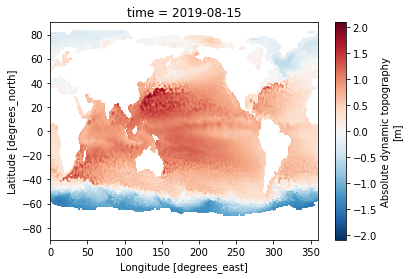

In [21]:
da.plot()

<hr>

<p><img src='./img/all_partners_wekeo.png' align='left' alt='Logo EU Copernicus' width='100%'></img></p>